In [1]:
import sys
sys.path.append('../../')
sys.path.append('/usr/users/fsimone/tejaas')

import numpy as np
import collections
import gzip
import random

from scipy import stats
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib
from utils import readgtf

# from utils import mpl_stylesheet
# mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt', dpi = 72)

In [2]:
import os, re
from functools import wraps
import time

def timeit(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time.time()
        result = f(*args, **kw)
        te = time.time()
        print('{:s} took: {:.6f} seconds'.format(f.__name__, te-ts))
        return result
    return wrap

SNPINFO_FIELDS = ['chrom', 'varid', 'bp_pos', 'ref_allele', 'alt_allele', 'maf']
class SnpInfo(collections.namedtuple('_SnpInfo', SNPINFO_FIELDS)):
    __slots__ = ()

SNP_COMPLEMENT = {'A':'T', 'C':'G', 'G':'C', 'T':'A'}

def HWEcheck(x):
    gt = x.tolist()
    f = np.array([0] * 3)
    f[0] = gt.count(0)
    f[1] = gt.count(1)
    f[2] = gt.count(2)
    n = sum(f)
    #p_A = (2 * f[0] + f[1]) / (2 * n)
    #p_a = (2 * f[2] + f[1]) / (2 * n)
    X2 = n * ( (4 * f[0] * f[2] - f[1] ** 2) / ((2 * f[0] + f[1]) * (2 * f[2] + f[1])) )**2
    pval = 1 - stats.chi2.cdf(X2, 1)
    return pval


def filter_snps(snpinfo, dosage):
        # Predixcan style filtering of snps
        newsnps = list()
        newdosage = list()
        npoly = 0
        nambi = 0
        nunkn = 0
        nlowf = 0
        nlowf_actual = 0
        nhwep = 0
        maf_limit = 0.01
        for i, snp in enumerate(snpinfo):
            pos = snp.bp_pos
            refAllele = snp.ref_allele
            effectAllele = snp.alt_allele
            rsid = snp.varid
            maf = round(snp.maf, 3)
            maf_actual = sum(dosage[i]) / 2 / len(dosage[i])
            # Skip non-single letter polymorphisms
            if len(refAllele) > 1 or len(effectAllele) > 1:
                npoly += 1
                continue
            # Skip ambiguous strands
            if SNP_COMPLEMENT[refAllele] == effectAllele:
                nambi += 1
                continue
            # Skip unknown RSIDs
            if rsid == '.':
                nunkn += 1
                continue
            # Skip low MAF
            if not (maf >= maf_limit and maf <= (1 - maf_limit)):
                nlowf += 1
                continue
            if not (maf_actual >= maf_limit and maf_actual <= (1 - maf_limit)):
                nlowf_actual += 1
                continue
            # if np.all(dosage[i] == dosage[i][0:]):
            #     nsame += 1
            #     continue
            # # Convert to integers 0, 1 or 2
            # bins = [0.66, 1.33]
            # intdosage = np.digitize(dosage[i], bins)
            # # Remove SNPs out of HWE
            # hwep = self.HWEcheck(intdosage)
            # if(hwep < 0.000001):
            #    nhwep += 1
            #    # self.logger.debug("SNP {:s} has a HWE p-value of {:g}".format(rsid, hwep))
            #    continue
            new_snp = snp._replace(maf = maf_actual)
            newsnps.append(new_snp)
            newdosage.append(dosage[i])
            # newdosage.append(intdosage)
        print("Removed {:d} SNPs because of non-single letter polymorphisms".format(npoly))
        print("Removed {:d} SNPs because of ambiguous strands".format(nambi))
        print("Removed {:d} SNPs because of unknown RSIDs".format(nunkn))
        print("Removed {:d} SNPs because of low MAF < {:g}".format(nlowf, maf_limit))
        print("Removed {:d} SNPs because of low MAF (current)".format(nlowf_actual))
        return newsnps, np.array(newdosage)   

def read_vcf(filename, startsnp, endsnp, mode="DS", samplefile=None, snplist=None):
    dosage = list()
    snpinfo = list()
    linenum = 0
    with gzip.open(filename, 'r') as vcf:
        for line in vcf:
            linestrip = line.decode().strip()
            if linestrip[:2] == '##': continue
            if linestrip[:6] == '#CHROM':
                linesplit = linestrip.split("\t")
                donor_ids = linesplit[9:]
            else:
                if linenum >= startsnp and linenum < endsnp:
                    linesplit = linestrip.split("\t")
                    if linesplit[0].startswith("chr"):
                        chrom = int(linesplit[0][3:])
                    else:
                        chrom = int(linesplit[0])
                    pos   = int(linesplit[1])
                    varid = linesplit[2]
                    ref   = linesplit[3]
                    alt   = linesplit[4]
    
                    if snplist is not None and varid not in snplist:
                        continue
                    
                    if mode == "DS":
                        if "DS" not in linesplit[8].split(':'):
                            mode = "GT"
                        else:
                            dsindx = linesplit[8].split(':').index("DS")
                            ds = [x.split(':')[dsindx] if len(x) > 1 else "." for x in linesplit[9:]]
                            gtindx = linesplit[8].split(':').index("GT")
                            for i, x in enumerate(ds):
                                if x == ".":
                                    gt = linesplit[9+i].split(':')[gtindx]
                                    if len(gt) == 3 and gt[0] != "." and gt[2] != ".":
                                        ds[i] = float(int(gt[0]) + int(gt[2]))

                    if mode == "GT":
                        if "GT" not in linesplit[8].split(':'):
                            print("ERROR: no GT field in VCF file")
                            raise
                        gtindx = linesplit[8].split(':').index("GT")
                        gt = [x.split(':')[gtindx] if len(x) > 1 else "." for x in linesplit[9:]]
                        ds = [ float(int(x[0]) + int(x[2])) if len(x) == 3 and x[0] != "." and x[2] != "." else "." for x in gt ]

                    ds_notna = [float(x) for x in ds if x != "."]
                    freq = sum(ds_notna) / 2 / len(ds_notna)
                    maf = freq
                    snpdosage = [float(x) if x != '.' else 2 * freq for x in ds]

                    this_snp = SnpInfo(chrom      = chrom,
                                       bp_pos     = pos,
                                       varid      = varid,
                                       ref_allele = ref,
                                       alt_allele = alt,
                                       maf        = maf)

                    dosage.append(snpdosage)
                    snpinfo.append(this_snp)
                linenum += 1
                
                if linenum > endsnp:
                    break
                    
    if samplefile is not None:
        if os.path.exists(samplefile):
            with open(samplefile, 'r') as samfile:
                sample = 0
                samplenames = list()
                next(samfile)
                next(samfile)
                for line in samfile:
                    if re.search('^#', line):
                        continue
                    samplenames.append(line.strip().split()[0])
            common_ids = [x for x in samplenames if x in donor_ids]
            print("GT Sample selection {:d} samples were retained from a total of {:d} samples".format(len(common_ids), len(donor_ids)))
            ix = [donor_ids.index(x) for x in common_ids]
            return np.array(dosage)[:,ix], snpinfo, common_ids
        else:
            print("samplefile does not exist")
            raise
    else:
        return np.array(dosage), snpinfo, donor_ids


def normalize_expr(Y):
    if isinstance(Y, pd.DataFrame):
        Y_cent = (Y.values - np.mean(Y.values, axis = 1).reshape(-1, 1)) / np.std(Y.values, axis = 1).reshape(-1, 1)
        Y_cent = pd.DataFrame(Y_cent, index=Y.index, columns=Y.columns)
        Y_cent.index.name = Y.index.name
    else:
        Y_cent = (Y - np.mean(Y, axis = 1).reshape(-1, 1)) / np.std(Y, axis = 1).reshape(-1, 1)
    return Y_cent

def select_donors(vcf_donors, expr_donors):
    ''' Make sure that donors are in the same order for both expression and genotype
    '''
    common_donors = [x for x in vcf_donors if x in expr_donors]
    vcfmask = np.array([vcf_donors.index(x) for x in common_donors])
    exprmask = np.array([expr_donors.index(x) for x in common_donors])
    return vcfmask, exprmask

def select_genes(info, names):
    ''' Select genes which would be analyzed. 
        Make sure the indices are not mixed up
    '''
    allowed = [x.ensembl_id for x in info]
    common  = [x for x in names if x in allowed]
    genes = [x for x in info if x.ensembl_id in common]
    indices = [names.index(x.ensembl_id) for x in genes]
    return genes, np.array(indices)

def normalize_and_center_dosage(dosage, snpinfo):
    f = [snp.maf for snp in snpinfo]
    f = np.array(f).reshape(-1, 1)
    gtnorm = (dosage - (2 * f)) / np.sqrt(2 * f * (1 - f))
    gtcent = dosage - np.mean(dosage, axis = 1).reshape(-1, 1)
    return gtnorm, gtcent #rr uses gtcent

def sample_gt(snpinfo, nsample):
    nsnps = len(snpinfo)
    dosages = np.zeros(nsnps * nsample)
    i = 0
    for snp in snpinfo:
        gtcent = sample_from_maf(nsample, snp.maf)
        dosages[i,:] = gtcent
        i += 1
    return dosages    

def sample_from_maf(nsample, maf):
    dosage = np.zeros(nsample)
    mafratios = np.array([(1 - maf)**2, 2 * maf * (1 - maf), maf**2])
    nfreq  = np.random.multinomial(nsample, mafratios, size=1)[0]
    f1 = np.repeat(0, nfreq[0])
    f2 = np.repeat(1, nfreq[1])
    f3 = np.repeat(2, nfreq[2])
    x  = np.concatenate((f1,f2,f3))
    dosage = np.random.permutation(x)
    # gtnorm = (dosage - (2 * maf2d)) / np.sqrt(2 * maf2d * (1 - maf2d))
    gtcent = dosage - np.mean(dosage)

    return gtcent

def simulate_gt(nsnps, nsample):
    mafs = np.linspace(0.1, 0.9, nsnps)
    gtcent = np.zeros((nsnps, nsample))
    snpinfo = list()
    for i in range(nsnps):
        gtcent[i,:] = sample_from_maf(nsample, mafs[i])
        this_snp = SnpInfo(chrom      = 1,
                           bp_pos     = i*100,
                           varid      = "rsid"+str(i),
                           ref_allele = "A",
                           alt_allele = "G",
                           maf        = mafs[i])
        snpinfo.append(this_snp)
    return gtcent, snpinfo

CISMASK_FIELDS = ['rmv_id', 'apply2']
class CisMask(collections.namedtuple('_CisMask', CISMASK_FIELDS)):
    __slots__ = ()

    @property
    def nsnp(self):
        return len(self.apply2)

    def __repr__(self):
        parent_string = super(CisMask, self).__repr__()
        return '{:s}, nsnp = {:d}'.format(parent_string, self.nsnp)

def get_cismasklist(snpinfo, geneinfo, chrom, window=1e6):
    chr_genes_ix = [[] for ichrm in range(22)] 
    chr_genes = [[] for ichrm in range(22)]
    if chrom is not None:
        chr_genes_ix[chrom - 1] = np.array([i for i, g in enumerate(geneinfo) if g.chrom == chrom])
        chr_genes[chrom - 1] = [geneinfo[ix] for ix in chr_genes_ix[chrom - 1]]
    else:
        for ichrm in range(22):
            chr_genes_ix[ichrm] = np.array([i for i, g in enumerate(geneinfo) if g.chrom == ichrm + 1])
            chr_genes[ichrm] = [geneinfo[ix] for ix in chr_genes_ix[ichrm]]
    genemasks = list()
    iprev = 0
    ichrmprev = 0
    for snp in snpinfo:
        pos = snp.bp_pos
        left = pos - window
        right = pos + window
        ichrm = chrom - 1 if chrom is not None else snp.chrom - 1
        iprev_started = False
        if ichrm != ichrmprev:
            iprev = 0
            ichrmprev = ichrm
        thismask = list()
        for i, g in enumerate(chr_genes[ichrm][iprev:]):
            gstart = g.start
            gend = g.end
            if gstart >= left and gstart <= right:
                # thismask.append(iprev + i)
                thismask.append(chr_genes_ix[ichrm][iprev + i])
                if not iprev_started:
                    new_start_iloc = iprev
                    iprev_started = True
            elif gend >= left and gend <= right:
                # thismask.append(iprev + i)
                thismask.append(chr_genes_ix[ichrm][iprev + i])
                if not iprev_started:
                    new_start_iloc = iprev
                    iprev_started = True
            if gstart > right:
                break
        if len(thismask) > 0:
            #genemasks.append(chr_genes_ix[np.array(thismask)])
            #iprev = thismask[0]
            genemasks.append(np.array(thismask))
            iprev = new_start_iloc
        else:
            genemasks.append(np.array([]))
    return genemasks

def compress_cismasklist(genemasks):
    cismasks = list()
    appendmask = False
    endmask = False
    setprev = False
    snplist = list()
    for i, mask in enumerate(genemasks):
        if not setprev:
            prev_mask = mask
            setprev = True
        if np.all(np.array_equal(mask, prev_mask)):
            snplist.append(i)
        else:
            appendmask = True

        if i == len(genemasks) - 1: endmask = True # no more masks to process

        if appendmask:
            thismask = CisMask(rmv_id = prev_mask, apply2 = snplist)
            cismasks.append(thismask)
            snplist = list([i])
            prev_mask = mask
            if not endmask:
                appendmask = False

        if endmask:
            # if not appendmask:
            #     snplist.append(i)
            thismask = CisMask(rmv_id = mask, apply2 = snplist)
            cismasks.append(thismask)

    return cismasks

def read_crossmap(crossmapfile):
    gene_pairs = collections.defaultdict(list)
    with gzip.open(crossmapfile, 'r') as instream:
        for line in instream:
            arr = line.rstrip().split()
            gene_pairs[arr[0].decode('utf-8')].append(arr[1].decode('utf-8'))
    return gene_pairs

def extend_cismask(genes, cismaskcomp, cross_gene_dict):
    # cross_gene_dict = read_crossmap(crossmapfile)
    genes_ix_dict = dict(zip([x.ensembl_id for x in genes], np.arange(len(genes))))
    crossmap_cismaskcomp = list()
    for cismask in cismaskcomp:
        gene_list = list()  # list of crossmapped genes for the cismask
        for gene in [genes[i] for i in cismask.rmv_id]:
            gene_list += cross_gene_dict[gene.ensembl_id]
        uniq_gene_list = list(set(gene_list))
        ugene_dict = collections.defaultdict(lambda: False) # significant speed-up by making a dict
        for g in uniq_gene_list:
            ugene_dict[g] = True
        cm_gene2rmv_ix = [genes_ix_dict[x.ensembl_id] for x in genes if ugene_dict[x.ensembl_id]]
        if len(cm_gene2rmv_ix) > 0:
            new_mask_genes = sorted(list(set(list(cismask.rmv_id) + cm_gene2rmv_ix)))
            new_cismask = cismask._replace(rmv_id = np.array(new_mask_genes))
            crossmap_cismaskcomp.append(new_cismask)
        else:
            crossmap_cismaskcomp.append(cismask)
    return crossmap_cismaskcomp

def knn_correction(expr, dosage, K, f=1):
    assert (expr.shape[0] == dosage.shape[1])
    pca = PCA(n_components=int(f * min(expr.shape[0], expr.shape[1]) ))
#     print("Original dimension: {:d} x {:d}".format(expr.shape[0], expr.shape[1]))
    pca.fit(expr) # requires N x G
    expr_pca = pca.transform(expr)
#     print("Reduced dimension: {:d} x {:d}".format(expr_pca.shape[0], expr_pca.shape[1]))

    def gene_distance(a, b):
        return np.linalg.norm(a - b)

    nsample = expr.shape[0]
    distance_matrix = np.zeros((nsample, nsample))
    for i in range(nsample):
        for j in range(i+1, nsample):
            dist = gene_distance(expr_pca[i,:], expr_pca[j,:])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    kneighbor = K
    gx_knn = np.zeros_like(expr)
    gt_knn = np.zeros_like(dosage)
    neighbor_list = list()

    for i in range(nsample):
        neighbors = np.argsort(distance_matrix[i, :])[:kneighbor + 1][1:]
        gx_knn[i, :] = expr[i, :] - np.mean(expr[neighbors, :], axis = 0)
        # noisy_neighbors = np.random.choice(neighbors, size = int(2 * kneighbor / 3), replace = False)
        # noisy_neighbors = np.random.choice(neighbors, size = kneighbor, replace = True )
        noisy_neighbors = neighbors
        gt_knn[:, i] = dosage[:, i] - np.mean(dosage[:, noisy_neighbors], axis = 1)
        neighbor_list.append(neighbors)

    return gx_knn, gt_knn

# # PCA correction - Won't work: makes some singular values == 0
def PCA_correction(gx, nComp = 5):
    pca = PCA()
    pca.fit(gx.T)
    gx_pca = np.dot(pca.transform(gx.T)[:, nComp:], pca.components_[nComp:,:]).T
    gx_pca_norm = normalize_expr(gx_pca)
    return gx_pca_norm

In [3]:
gencode_file = "/cbscratch/franco/datasets/GENCODE/gencode.v26.annotation.gtf.gz"
geneinfo = readgtf.gencode_v12(gencode_file, biotype = ["protein_coding", "lncRNA"])

Mode v26


In [4]:
import pandas as pd

IS_SIMULATION=False
ts='wb'

if IS_SIMULATION:
    basedir = "/cbscratch/franco/trans-eqtl/simulation/ldpruned2"
    paramstr = "15064_450_10_800_30_100_100_0.01_0.5_0.0_1.0_0.6_4.0_0.1_20_0.02"
    method = "tejaas/permnull_sb0.1/peer0"
    simname = "sim001"
    gx_sim_file = os.path.join(basedir, paramstr, simname, "input", "gx_raw.txt")

    df = pd.read_csv(gx_sim_file, header=0, index_col=0, sep="\t")
    window=1

else:
    gx_file = f"/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms/{ts}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered"
    df = pd.read_csv(gx_file, header=0, index_col=0, sep="\t")
    
    window=1e6

ngene, nsample = df.shape
gx_donors = list(df.columns)
gx = df.values
gene_names = list(df.index)
print(gx.shape)
print("Matrix rank:", np.linalg.matrix_rank(gx))


(11995, 670)
Matrix rank: 669


In [5]:
import collections

GENEINFO_FIELDS = ['name', 'ensembl_id', 'chrom', 'start', 'end', 'typ']
class GeneInfo(collections.namedtuple('_GeneInfo', GENEINFO_FIELDS)):
    __slots__ = ()
    
if IS_SIMULATION:
    genepos_file = os.path.join(basedir, paramstr, simname, "input","expression.genepos")
    geneinfo = list()
    with open(genepos_file) as inst:
        next(inst)
        for line in inst:
            arr = line.rstrip().split()
            name = arr[0]
            ensembl_id = arr[0]
            chrom = int(arr[1][3:])
            start = int(arr[2])
            end = int(arr[3])
            geneinfo.append(GeneInfo(name=name, ensembl_id=ensembl_id, chrom=chrom, start=start, end=end, typ="null"))


In [125]:
import copy

########### from Simulations ###########
if IS_SIMULATION:
    f_vcf = os.path.join(basedir, paramstr, simname, "input", "genotype.vcf.gz")
    samplefile = os.path.join(basedir, paramstr, simname, "input", f"{simname}.sample")
    gtfull, snpinfos, gt_donors = read_vcf(f_vcf, 0, 100, samplefile=samplefile)
else:
########### from GTEx real data ###########
    ts = 'wb'
    chrm = 1
    f_vcf = f"/cbscratch/franco/datasets/gtex_v8/genotypes/vcfs_SHAPEIT2/0.01/GTEX_v8_2020-02-21_WGS_838Indiv_Freeze.SHAPEIT2_phased_NoMissingGT_SNPfilter_MAF0.01_chr{chrm}.vcf.gz"
    snps_file = f"{ts}_crossmap_chr{chrm}_snps_brought_in.txt"
    with open(snps_file) as inst:
        mysnpslist = inst.read().split()
    mysnpslist = None
    gtfull, snpinfos, gt_donors = read_vcf(f_vcf, 0, 5000, snplist=mysnpslist) ### Selects specific SNPs!

vcfmask, exprmask = select_donors(gt_donors, gx_donors)
genes, indices = select_genes(geneinfo, gene_names)
dosage_masked = gtfull[:, vcfmask]

snp_info, dosage = filter_snps(snpinfos, dosage_masked)
print(f"Loaded {len(snp_info)} SNPs")
# Use artificial genotype
# gtfull, snp_info = simulate_gt(10000, len(gt_donors))


Removed 0 SNPs because of non-single letter polymorphisms
Removed 0 SNPs because of ambiguous strands
Removed 0 SNPs because of unknown RSIDs
Removed 0 SNPs because of low MAF < 0.01
Removed 146 SNPs because of low MAF (current)
Loaded 4854 SNPs


In [7]:
crossmapfile = "/cbscratch/franco/datasets/crossmappability/hg38_cross_mappability_strength.txt.gz"
cross_gene_dict = read_crossmap(crossmapfile)

In [126]:
gx_norm = normalize_expr( gx[:, exprmask][indices,:] )
nsample = gx_norm.shape[1]

print(gx_norm.shape)

## --- Apply KNN correction
f=1
gx_knn, gt_knn = knn_correction(gx_norm.T, dosage, K=30, f=f)

## --- Normalize GX and GT
gt_norm, gt_cent = normalize_and_center_dosage(dosage, snp_info)
sigmax2     = np.var(gt_cent, axis = 1)

gx_knn_norm = normalize_expr(gx_knn.T)
gt_knn_norm, gt_knn_cent = normalize_and_center_dosage(gt_knn, snp_info)
sigmax2_knn = np.var(gt_knn_cent, axis = 1)

shuffle_mask = np.arange(nsample)
np.random.shuffle(shuffle_mask)
gx_shuffled_norm = copy.deepcopy(gx_norm[:, shuffle_mask])
gx_shuffled_knn_norm = copy.deepcopy(gx_knn_norm[:, shuffle_mask])

(11995, 670)


In [127]:
## --- Obtain CisMasks
cismasklist = get_cismasklist(snp_info, genes, None, window=window)
cismaskcomp = compress_cismasklist(cismasklist)
cismaskcomp_crossmap = extend_cismask(genes, cismaskcomp, cross_gene_dict)


In [128]:
def pvals_perm(GT, R, W):
    mu2, mu4 = moment_data(GT)
    N = GT.shape[1]
    q11 = np.sum(W)
    q2  = np.sum(np.diag(W))
    muQ = mu2 * (N * q2 - q11) / (N - 1)

    v31 = - mu4 / (N - 1)
    v22 = v31 + (N * mu2 * mu2 / (N - 1)) #(N*(mu2**2) - mu4)/(N-1)
    v211 = - (v31 + v22) / (N - 2)
    v1111 = - 3 * v211 / (N - 3)

    q31 = np.dot(np.diag(W),np.sum(W,axis = 1))
    q4 = np.sum(np.square(np.diag(W)))
    q22 = np.sum(np.square(W))
    q211 = np.sum(np.square(np.sum(W,axis = 1)))

    sigma2 = v1111*(q11**2 - 2*q2*q11 - 4*q211 + 8*q31 + 2*q22 + q2**2 - 6*q4) + 2*v211*(q2*q11 + 2*q211 - 6*q31 - 2*q22 - q2**2 + 6*q4) + v22*(q2**2 + 2*q22 - 3*q4) + 4*v31*(q31 - q4) + mu4*q4

    sigma2 = sigma2 - muQ**2
    sigmaQ = np.sqrt(sigma2)
    p = 1 - stats.norm.cdf(R, loc=muQ, scale=sigmaQ)
    return p, muQ, sigmaQ

def moment_data(GT):   #GT ixN
    GT2 = np.square(GT)
    GT4 = np.square(GT2)
    mu2 = np.mean(GT2)
    mu4 = np.mean(GT4)
    return mu2, mu4

In [129]:
from scipy.optimize import minimize

class SBoptimizer:

    def __init__(self, GT, GX, sx2):

        self._GT  = np.ascontiguousarray(GT)
        self._GX  = np.ascontiguousarray(GX)
        self._sx2 = np.ascontiguousarray(sx2)
        self._nsnps = GT.shape[0]
        self._nsample = GX.shape[1]
        
        U, S, VT = np.linalg.svd(GX.T)
        self._S = S
        self._U = U
        self._S2 = np.square(S)
        self._opt_sb2 = np.zeros(self._nsnps)
    
    @property
    def sb2(self):
        return self._opt_sb2

    def get_ML(self, _sb2, i):
        # sb2 = sb * sb
        sb2 = np.exp(_sb2)
        S2mod = self._S2 + (self._sx2[i] / sb2)
        Rscore = np.sum(np.square(np.dot(self._U.T, self._GT[i,:])) * (self._S2 / S2mod)) / self._sx2[i]
        MLL = -0.5*np.sum(np.log( self._S2 * (sb2 / self._sx2[i]) + 1 )) + 0.5*Rscore

        denom = (self._S2 * sb2 + self._sx2[i])
        der = 0.5* np.sum( ( self._S2 / denom ) * ( (np.square(np.dot(self._U.T, self._GT[i,:])) / denom ) - 1 ) )
        return -MLL, sb2*np.array([-der])

    def fit(self):
        st = time.time()
        
        sb_init = np.exp(0.01)
        for i in range(self._nsnps):
            res = minimize(   self.get_ML,
                              sb_init, 
                              args = i,
                              method='L-BFGS-B',
                              jac = True,
                              #bounds = [[0,1]],
                              options={'maxiter': 200000,
                                       'maxfun': 2000000,
                                       #'ftol': 1e-9,
                                       #'gtol': 1e-9,
                                       'disp': True})

            # print(res)
            self._opt_sb2[i] = np.exp(res.x[0])
        et = time.time()
        print("optimization took in total: ",et-st)

(11995, 670)
(4854, 670)
====== Norm KNN ======
Found 41 cismasks.
Processing cismask 0: 6 genes masked for 9 snps
Empirical scaledQ mean 0.018260625038652955
Empirical values: mean 669.285 | sigma 0.484 | skew -1.360
Analyticl values: mean 669.276 | sigma 0.482
alpha 2.16187481634793, beta 1.4703315328006572, gamma 1.4703315328006572, Qx 0.7801413131669809
pval 0.24503728652503032, pval_corr 0.0, pval_corr0 0.07630581546848932


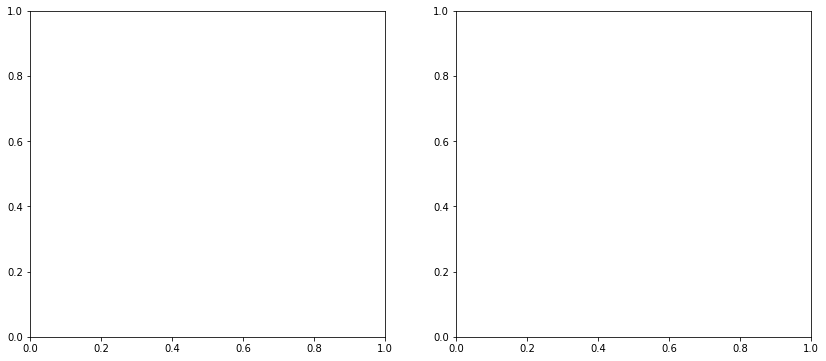

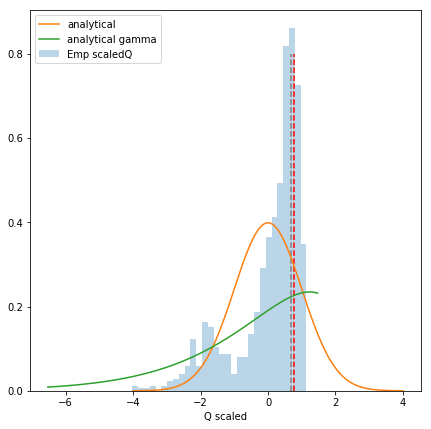

Empirical scaledQ mean -0.017018044725901897
Empirical values: mean 667.666 | sigma 0.693 | skew -0.414
Analyticl values: mean 667.678 | sigma 0.699
alpha 23.371907618125277, beta 4.834450084355539, gamma 4.834450084355539, Qx 3.525591987004708
pval 0.09529121142481767, pval_corr 0.0, pval_corr0 3.699419702611956e-27


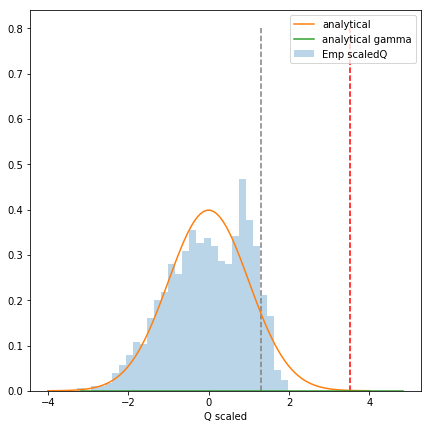

Empirical scaledQ mean 0.004104426738434085
Empirical values: mean 668.037 | sigma 0.701 | skew -0.626
Analyticl values: mean 668.034 | sigma 0.679
alpha 10.199730191038775, beta 3.1937016440235575, gamma 3.1937016440235575, Qx 4.168606708428986
pval 0.8351963231248798, pval_corr 7.22065698258185e-13, pval_corr0 7.977200813977931e-07


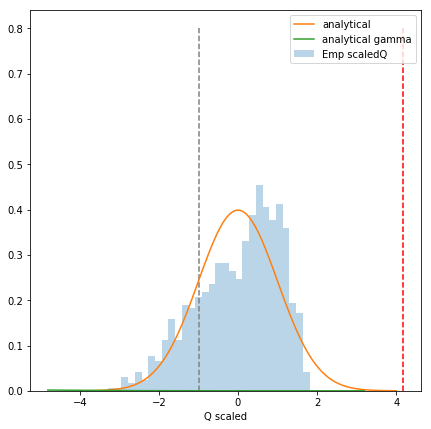

Empirical scaledQ mean 0.04792385882635719
Empirical values: mean 669.366 | sigma 0.446 | skew -1.376
Analyticl values: mean 669.344 | sigma 0.472
alpha 2.113952557222273, beta 1.4539437943821187, gamma 1.4539437943821187, Qx 1.5855089293194327
pval 0.5523358679810246, pval_corr 0.0026297144838314294, pval_corr0 0.2658042000420596


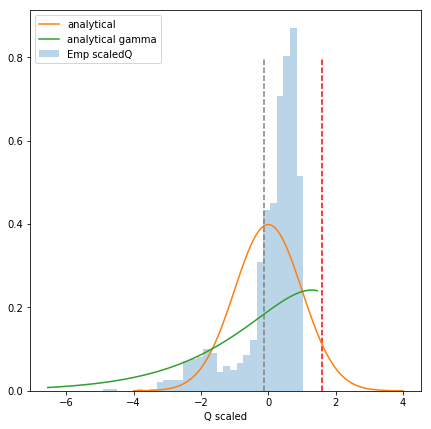

Empirical scaledQ mean 0.06475404710219548
Empirical values: mean 669.273 | sigma 0.469 | skew -1.066
Analyticl values: mean 669.241 | sigma 0.498
alpha 3.5227739291706706, beta 1.8769054129525735, gamma 1.8769054129525735, Qx 1.2626735317169016
pval 0.26953105437018654, pval_corr 0.0, pval_corr0 0.012295761383211725


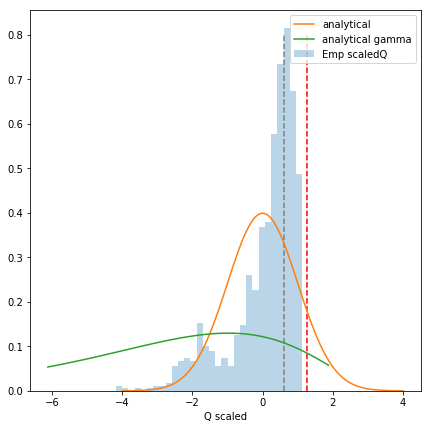

Empirical scaledQ mean -0.07484691359564453
Empirical values: mean 668.645 | sigma 0.640 | skew -1.306
Analyticl values: mean 668.691 | sigma 0.607


RuntimeError: No active exception to reraise

In [229]:
import random

def tejaas_rr(myGT, myGX, sigmax2, sb2):
    nsnps  = myGT.shape[0]
    Rscore = np.zeros(nsnps)
    Rscore_corr = np.zeros(nsnps)
    pvals  = np.zeros(nsnps)
    pvals_corr   = np.zeros(nsnps)
    pvals_corr0  = np.zeros(nsnps)
    muQ    = np.zeros(nsnps)
    sigmaQ = np.zeros(nsnps)
    Keff   = np.zeros(nsnps)
    Skew   = np.zeros(nsnps)
#     EmuQ   = np.zeros(nsnps)
#     EsigmaQ= np.zeros(nsnps)
    
    # Yt = (GX / np.sqrt(nsample)).T
    Yt = myGX.T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    S2 = np.square(S)
    
    counter=0
    for j in range(nsnps):       
        S2mod = S2 + (sigmax2[j] / sb2[j])
        Keff[j] = np.sum(S2/S2mod)
        
        W = np.dot(U, np.dot(np.diag(S2 / S2mod), U.T)) / sigmax2[j]
        Rscore[j] = np.sum(np.square(np.dot(U.T, myGT[j,:])) * (S2 / S2mod)) / sigmax2[j]
        
        pvals[j], muQ[j], sigmaQ[j] = pvals_perm(myGT[j, :].reshape(1, -1), Rscore[j], W)
        
        ####################################
        #### Skewness correction 24/02/2021  
        nit = 1000
        rand_gt = copy.deepcopy(myGT[j,:])
        emp_q = np.zeros(nit)
        for k in range(nit):
            random.shuffle(rand_gt)
            emp_q[k] = np.sum(np.square(np.dot(U.T, rand_gt)) * (S2 / S2mod)) / sigmax2[j]
        EmuQ     = np.mean(emp_q)
        EsigmaQ  = np.std(emp_q)
        EscaledQ = (emp_q - muQ[j]) / sigmaQ[j]
        scaledQ  = (Rscore[j] - muQ[j]) / sigmaQ[j]
        EskewQ   = np.sum(EscaledQ**3) / len(EscaledQ)  # Eq 41
        print(f"Empirical scaledQ mean {np.mean(EscaledQ)}")
        print(f"Empirical values: mean {EmuQ:.3f} | sigma {EsigmaQ:.3f} | skew {EskewQ:.3f}")
        print(f"Analyticl values: mean {muQ[j]:.3f} | sigma {sigmaQ[j]:.3f}")
        
        if counter > 4:
            raise
        filename = f"snp{j}_sb{np.sqrt(sb2[j])}_mu{muQ[j]:.2f}_sigma{sigmaQ[j]:.2f}.txt"
        np.savetxt(filename, EscaledQ)    
        counter += 1
        
        
        if EskewQ > 0:
            alpha= 4 / EskewQ**2
            beta = 2 / EskewQ
            gamma= 2 / EskewQ
            Qx = scaledQ - gamma
            pval_gamma  = 1 - stats.gamma.cdf(Qx, alpha, loc=gamma, scale=beta)
            pval_gamma0 = 1 - stats.gamma.cdf(Qx, alpha, loc=0, scale=beta)
        else:
            alpha= 4 / EskewQ**2
            beta = 2 / np.abs(EskewQ)
            gamma= 2 / np.abs(EskewQ)
            mean = -alpha/beta + gamma
            vari = alpha/(beta**2)
            
            Qx = -scaledQ + gamma
            pval_gamma  = stats.gamma.cdf(Qx, alpha, loc=gamma, scale=beta)
            pval_gamma0 = stats.gamma.cdf(Qx, alpha, loc=0, scale=beta)
        print(f"alpha {alpha}, beta {beta}, gamma {gamma}, Qx {Qx}")

        # p = 1 - stats.norm.cdf(R, loc=muQ, scale=sigmaQ)
        # print(Qx, pval_gamma, pval_gamma0, alpha, beta, gamma)
        pvals_corr[j]  = pval_gamma
        pvals_corr0[j] = pval_gamma0
        Rscore_corr[j] = Qx
        Skew[j] = EskewQ
        
        print(f"pval {pvals[j]}, pval_corr {pval_gamma}, pval_corr0 {pval_gamma0}")
        
        fig = plt.figure(figsize=(7,7))
        ax1 = fig.add_subplot(111)
        ax1.hist(EscaledQ, bins=30, alpha=0.3, density=True, label="Emp scaledQ")
        ax1.vlines(scaledQ, 0, 0.8, linestyle='dashed', color="gray")
        ax1.set_xlabel("Q scaled")

        x  = np.linspace(-4, 4, 100)
        x2 = np.linspace(0, 8, 100)
        rv = stats.norm(loc = 0, scale = 1)
        ax1.plot(x, rv.pdf(x), label = 'analytical')
        
        if EskewQ > 0:
            rv = stats.gamma(loc = gamma, scale = beta, a = alpha)
            ax1.plot(x2-gamma, rv.pdf(x2), label = 'analytical gamma')
            ax1.vlines(Qx, 0, 0.8, linestyle='dashed', color="red")
        else:
            rv = stats.gamma(loc = -gamma, scale = beta, a = alpha)
            ax1.plot(-x2+gamma, rv.pdf(x2), label = 'analytical gamma')
            ax1.vlines(Qx, 0, 0.8, linestyle='dashed', color="red")
        
        ax1.legend()
        plt.show()
        ####################################
        ####################################
        
    return S2, pvals, Rscore, muQ, sigmaQ, Keff, Rscore_corr, pvals_corr, pvals_corr0, Skew

def compare_basic_props(GX, GT, ax1, ax2, label, sigmax2, sb2 = None, cismasks = None):
        
    nsnps  = GT.shape[0]
    Rscore = np.zeros(nsnps)
    pvals  = np.zeros(nsnps)
    Rscore_corr = np.zeros(nsnps)
    pvals_corr  = np.zeros(nsnps)
    pvals_corr0 = np.zeros(nsnps)
    skewness = np.zeros(nsnps)
    muQ    = np.zeros(nsnps)
    sigmaQ = np.zeros(nsnps)
    Keff   = np.zeros(nsnps)
    EmuQ   = np.zeros(nsnps)
    EsigmaQ= np.zeros(nsnps)
    myGT = GT
    myGX = GX
    opt_sb2 = np.zeros(nsnps)
    
    print("====== {:s} ======".format(label))
    Yt = myGX.T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    S2 = np.square(S, dtype=np.float64 )
       
    if cismasks is not None:
        nmasks = len(cismasks)
        print("Found {:d} cismasks.".format(nmasks))
        for i,cismask in enumerate(cismasks):
            print("Processing cismask {:d}: {:d} genes masked for {:d} snps".format(i, len(cismask.rmv_id), cismask.nsnp))
            usegenes = np.ones(GX.shape[0], dtype=bool)
            if cismask.rmv_id.shape[0] > 0: usegenes[cismask.rmv_id] = False
            myGX = GX[usegenes]
            myGT = GT[cismask.apply2,:]
            
#             SBOPT = SBoptimizer(myGT, myGX, sigmax2[cismask.apply2])
#             SBOPT.fit()
#             sb2 = SBOPT.sb2
#             opt_sb2[cismask.apply2] = SBOPT.sb2
            
            _s2, _pvals, _qscores, _muq, _sigmaq, _keff, _qscorescorr, _pvalscorr, _pvalscorr0, _skew = tejaas_rr(myGT, myGX, sigmax2[cismask.apply2], sb2) #[cismask.apply2])
            pvals[cismask.apply2]  = _pvals
            Rscore[cismask.apply2] = _qscores
            muQ[cismask.apply2]    = _muq
            sigmaQ[cismask.apply2] = _sigmaq
            Keff[cismask.apply2]   = _keff
            Rscore_corr[cismask.apply2] = _qscorescorr
            pvals_corr[cismask.apply2]  = _pvalscorr
            pvals_corr0[cismask.apply2]  = _pvalscorr0
            skewness[cismask.apply2] = _skew
#             EmuQ[cismask.apply2]   = _emuq
#             EsigmaQ[cismask.apply2]= _esigq
            
    else:
        raise
        S2, pvals, Rscore, muQ, sigmaQ = tejaas_rr(myGT, myGX, sigmax2, sb2) 
    
    ax1.scatter(np.arange(len(S)-1), S[:-1], label = label, alpha=0.4)
    ax2.hist(Rscore, bins=30, label = label, alpha=0.4)
    return S2, pvals, Rscore, muQ, sigmaQ, opt_sb2, Keff, Rscore_corr, pvals_corr, pvals_corr0, skewness

fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sbeta = 0.1
sb2 = np.repeat(sbeta*sbeta, gt_cent.shape[0])

print(gx_norm.shape)
print(gt_cent.shape)

# - With KNN
S2, pvals, Q, muQ, sigmaQ, opt_sb2, Keff, Qcorr, pvals_corr, pvals_corr0, skewness = compare_basic_props(gx_knn_norm, 
                                                                gt_knn_cent, 
                                                                ax1, ax2, 
                                                                'Norm KNN', 
                                                                sigmax2_knn, 
                                                                sb2 = sb2, 
                                                                cismasks=cismaskcomp)

# S2_cm, pvals_cm, Q_cm, muQ_cm, sigmaQ_cm, opt_sb2_cm, Keff_cm, Qcorr_cm, pvals_corr_cm = compare_basic_props(gx_knn_norm, 
#                                                                 gt_knn_cent, 
#                                                                 ax1, ax2, 
#                                                                 'Norm KNN', 
#                                                                 sigmax2_knn, 
#                                                                 sb2 = sb2, 
#                                                                 cismasks=cismaskcomp_crossmap)

ax1.set_xlabel("Singular values (rank)")
ax1.set_ylabel("Singular values S (value)")
ax1.legend()
ax2.set_xlabel("Q score")
ax2.legend()
plt.tight_layout()
plt.show()

# Empirical values: mean 669.279 | sigma 0.479 | skew -1.447
# Analyticl values: mean 669.276 | sigma 0.482
# alpha 1.911016628140424, beta 1.3823952503319823, gamma 1.3823952503319823

In [198]:
# Save results
with open(f"skew_correction_data_sb{sbeta}", 'w') as outst:
    outst.write("\t".join(["snpid", "maf", "Q", "muQ", "sigmaQ", "Qcorr", "pval", "pval_corr0", "pval_corr", "skewness"])+"\n")
    for i,s in enumerate(snp_info):
        outst.write(f"{s.varid}\t{s.maf}\t{Q[i]}\t{muQ[i]}\t{scaledQ[i]}\t{Qcorr[i]}\t{pvals[i]}\t{pvals_corr0[i]}\t{pvals_corr[i]}\t{skewness[i]}\n")

In [221]:
indx = skewness < -1.7 #-np.sqrt(np.pi) #-1.7
Qcorr_selected = Qcorr[indx]
Q_norms = (Q - muQ) / scaledQ
print(np.sum(indx))

1118


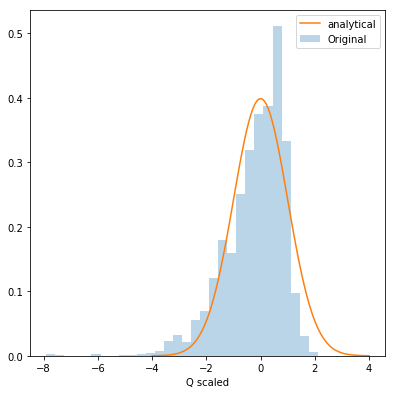

In [216]:
fig = plt.figure(figsize=(14,14))
ax1 = fig.add_subplot(221)
ax1.hist(Q_norms, bins=30, alpha=0.3, density=True, label="Original")
ax1.set_xlabel("Q scaled")

x = np.linspace(-4, 4, 100)
rv = stats.norm(loc = 0, scale = 1)
ax1.plot(x, rv.pdf(x), label = 'analytical')

ax1.legend()
plt.show()

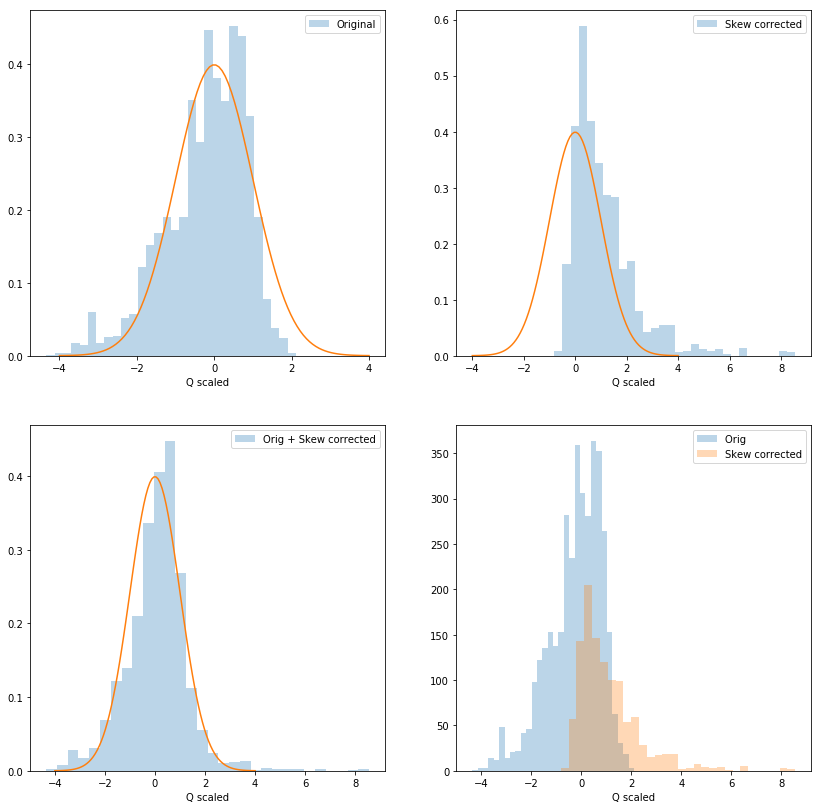

In [217]:
# qscaled_knn = (Q - muQ)/ scaledQ
qscaled_knn = Q_norms[~indx]

qscaled_corr = Qcorr_selected #(Qcorr - muQ)/ scaledQ

fig = plt.figure(figsize=(14,14))
ax1 = fig.add_subplot(221)
ax1.hist(qscaled_knn, bins=30, alpha=0.3, density=True, label="Original")
ax1.set_xlabel("Q scaled")
ax1.legend()

ax2 = fig.add_subplot(222)
ax2.hist(qscaled_corr, bins=30, alpha=0.3, density=True, label="Skew corrected")
ax2.set_xlabel("Q scaled")
ax2.legend()


ax3 = fig.add_subplot(223)
ax3.hist(np.concatenate((qscaled_corr, qscaled_knn)), bins=30, alpha=0.3, density=True, label="Orig + Skew corrected")
ax3.set_xlabel("Q scaled")
ax3.legend()

ax4 = fig.add_subplot(224)
ax4.hist(qscaled_knn, bins=30, alpha=0.3, density=False, label="Orig ")
ax4.hist(qscaled_corr, bins=30, alpha=0.3, density=False, label="Skew corrected")
ax4.set_xlabel("Q scaled")
ax4.legend()


x = np.linspace(-4, 4, 100)
rv = stats.norm(loc = 0, scale = 1)
ax1.plot(x, rv.pdf(x), label = 'analytical')
ax2.plot(x, rv.pdf(x), label = 'analytical')
ax3.plot(x, rv.pdf(x), label = 'analytical')

plt.show()

/usr/product/applsw/conda/2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


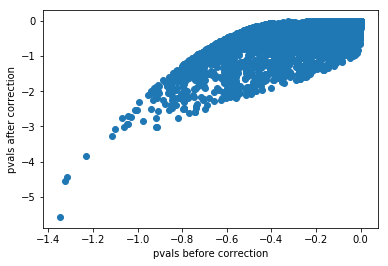

In [203]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(np.log10(pvals[indx]), np.log10(pvals_corr0[indx]))
ax1.set_xlabel("pvals before correction")
ax1.set_ylabel("pvals after correction")
plt.show()

/usr/product/applsw/conda/2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


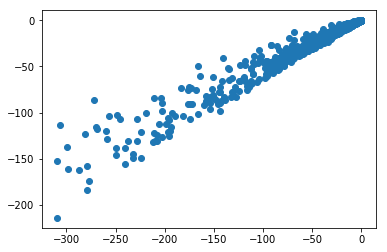

In [191]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(np.log10(pvals_corr), np.log10(pvals_corr0))
# ax1.scatter(np.log10(pvals[~indx]), np.log10(pvals_corr0[~indx]), alpha=0.2)
plt.show()

In [184]:
print(Q_norms[indx][qscaled_corr > 8])
print(pvals_corr0[indx][qscaled_corr > 8])
print(skewness[indx][qscaled_corr > 8])


[-7.63145105 -7.48185653 -7.76990924 -7.90577569 -7.90716291]
[0.99999999 0.99999993 1.         1.         0.99999984]
[-3.81609743 -3.40701834 -4.55496877 -3.80282608 -3.11802797]


In [186]:
np.min(skewness)

-6.798786641378582

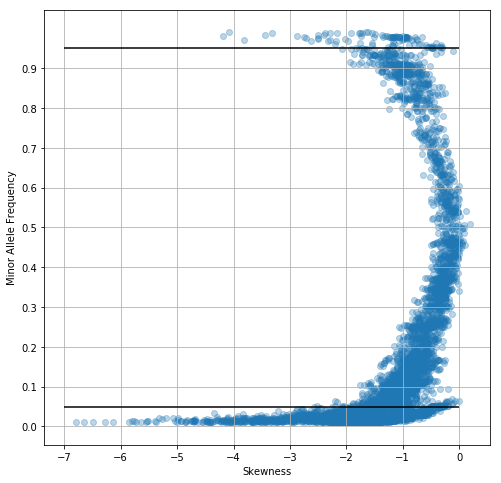

In [171]:
mafs = [x.maf for x in snp_info]
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
ax1.scatter(skewness, mafs, alpha=0.3)
#ax1.hlines([0.05, 0.95], -7, 0)
ax1.set_yticks(np.arange(0,1,0.1))
ax1.set_xlabel("Skewness")
ax1.set_ylabel("Minor Allele Frequency")
ax1.grid()
# ax1.scatter(np.log10(pvals[~indx]), np.log10(pvals_corr0[~indx]), alpha=0.2)
plt.show()

# Single SNP Q distribution

In [ ]:
Y = gx_knn_norm
Yt = Y.T
U, S, Vt = np.linalg.svd(Yt, full_matrices=False)

# sb2_opt_K_knn = optimize_sb2(S, sigmax2_knn, 0.6)

def tejaas_rr_single_SNP(myGT, myGX, sigmax2, sb2, j):
    it = 10000
    nsnps  = myGT.shape[0]
    muQ    = np.zeros(nsnps)
    sigmaQ = np.zeros(nsnps)
    Keff   = np.zeros(nsnps)
    randQ  = np.zeros(it)
    
    Yt = myGX.T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    S2 = np.square(S)
    
    S2mod = S2 + (sigmax2 / sb2)
    Keff = np.sum(S2/S2mod)

    W = np.dot(U, np.dot(np.diag(S2 / S2mod), U.T)) / sigmax2
    Rscore = np.sum(np.square(np.dot(U.T, myGT[j,:])) * (S2 / S2mod)) / sigmax2

    pval, muQ, sigmaQ = pvals_perm(myGT[j, :].reshape(1, -1), Rscore, W)

    rand_gt = copy.deepcopy(myGT[j,:])
    for k in range(it):
        random.shuffle(rand_gt)
        randQ[k] = np.sum(np.square(np.dot(U.T, rand_gt)) * (S2 / S2mod)) / sigmax2      
        
    return pval, Rscore, muQ, sigmaQ, Keff, randQ

def shuffle_single_snp(GX, GT, label, sigmax2, sb2 = None, cismasks = None):
    nsnps  = GT.shape[0]
    Rscore = np.zeros(nsnps)
    pvals  = np.zeros(nsnps)
    muQ    = np.zeros(nsnps)
    sigmaQ = np.zeros(nsnps)
    Keff   = np.zeros(nsnps)
    EmuQ   = np.zeros(nsnps)
    EsigmaQ= np.zeros(nsnps)
    myGT = GT
    myGX = GX
    opt_sb2 = np.zeros(nsnps)
    
    print("====== {:s} ======".format(label))
    Yt = myGX.T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    S2 = np.square(S, dtype=np.float64 )
        
    if cismasks is not None:
        nmasks = len(cismasks)
        print("Found {:d} cismasks.".format(nmasks))
        for i,cismask in enumerate(cismasks):
            print("Processing cismask {:d}: {:d} genes masked for {:d} snps".format(i, len(cismask.rmv_id), cismask.nsnp))
            usegenes = np.ones(GX.shape[0], dtype=bool)
            if cismask.rmv_id.shape[0] > 0: usegenes[cismask.rmv_id] = False
            myGX = GX[usegenes]
            myGT = GT[cismask.apply2,:]
            
#             SBOPT = SBoptimizer(myGT, myGX, sigmax2[cismask.apply2])
#             SBOPT.fit()
#             sb2 = SBOPT.sb2
#             opt_sb2[cismask.apply2] = SBOPT.sb2
            
            # Select SNP here based on..
            j = np.argsort(sigmax2[cismask.apply2])[0]
            print("Selected SNP {:d} with sb2: {:g} sx2: {:g}".format(j, sb2[j], sigmax2[cismask.apply2][j]))
            pvals, Q, muQ, sigmaQ, Keff, randQ = tejaas_rr_single_SNP(myGT, myGX, sigmax2[cismask.apply2][j], sb2[j], j)
            print("Keff: {:g}".format(Keff))
            print("Matrix rank: {:d} / {:d}".format(np.sum(S > 1), myGX.shape[1]))
            print("Pvals:",pvals)
            print("SX2:", sigmax2[j])
    else:
        print("failed to provide cismask")
        raise
    return pvals, Q, muQ, sigmaQ, opt_sb2, Keff, randQ

sbeta = 0.1
sb2 = np.repeat(sbeta*sbeta, 10)

# sb2 = np.repeat(0.1*0.1, 10)

pvals_s, Q_s, muQ_s, sigmaQ_s, opt_sb2_s, Keff_s, randQ_s = shuffle_single_snp( gx_knn_norm, 
                                                                  gt_knn_cent,
                                                                  "Norm, KNN",
                                                                  sigmax2_knn,
                                                                  sb2 = sb2, #sb2_opt_K_knn,
                                                                  cismasks=[cismaskcomp[0]])

pvals_scm, Q_scm, muQ_scm, sigmaQ_scm, opt_sb2_scm, Keff_scm, randQ_scm = shuffle_single_snp( gx_knn_norm, 
                                                                  gt_knn_cent,
                                                                  "Norm, KNN",
                                                                  sigmax2_knn,
                                                                  sb2 = sb2, #sb2_opt_K_knn,
                                                                  cismasks=[cismaskcomp_crossmap[0]])

# s_pvals, s_Q, s_muQ, s_sigmaQ, s_opt_sb2, s_Keff, s_randQ = shuffle_single_snp( gx_shuffled_knn_norm, 
#                                                                                 gt_knn_cent,
#                                                                                 "Norm, KNN - Shuffled",
#                                                                                 sigmax2_knn,
#                                                                                 sb2 = sb2_opt_K_knn,
#                                                                                 cismasks=cismaskcomp)


In [ ]:
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(121)

randQ_s_scaled = (randQ_s - muQ_s)/ sigmaQ_s
randQ_scm_scaled = (randQ_scm - muQ_scm)/ sigmaQ_scm


ax1.hist(randQ_s_scaled, bins=50, alpha=0.3, density=True, label="Empirical")
# ax1.axvline((Q_s- muQ_s)/ sigmaQ_s, linestyle="--", color="red")
ax1.set_xlabel("Q score")
ax1.set_title(f"Empirical Q shuffling - Crossmap OFF - sb{sbeta}")


ax2 = fig.add_subplot(122)
ax2.hist(randQ_scm_scaled, bins=50, alpha=0.3, density=True, label="Empirical")
# ax2.axvline((Q_scm- muQ_scm)/ sigmaQ_scm, linestyle="--", color="red")
ax2.set_xlabel("Q score")
ax2.set_title(f"Empirical Q shuffling - Crossmap ON - sb{sbeta}")


x = np.linspace(-4, 4, 100)
rv = stats.norm(loc = 0, scale = 1)
ax1.plot(x, rv.pdf(x), label = 'analytical')
ax2.plot(x, rv.pdf(x), label = 'analytical')
ax1.legend()
ax2.legend()

plt.tight_layout()
plt.show()